# Import Libraries

In [54]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import glob
import matplotlib.dates as mdates
import os
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from datetime import timedelta
from matplotlib.ticker import ScalarFormatter, LogLocator
from matplotlib.ticker import FuncFormatter, LogLocator
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, LogFormatter
from scipy.stats import zscore
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import pytz
import matplotlib.ticker as ticker

# Set Plotting Parameters

Fontsize, linewidth, etc. Feel free to change these as you wish

In [55]:
np.set_printoptions(precision = 4)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = '1.5'
mpl.rcParams['ytick.major.width'] = '1.5'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.major.size'] = '10.0'
mpl.rcParams['ytick.major.size'] = '10.0'
mpl.rcParams['xtick.minor.size'] = '5.0'
mpl.rcParams['ytick.minor.size'] = '5.0'
mpl.rcParams['axes.linewidth'] = '1.5'
mpl.rcParams['axes.labelsize'] = '20'
mpl.rcParams['axes.titlesize'] = '20' 
mpl.rcParams['figure.titlesize'] = '20'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

# Define paths

In [56]:
# Path to Pico Rivera SMPS data file (the cleaned_csv saved at the end of code in cleaning_smps_csv_VIB.ipynb)
pathp = '/Users/vineblankenship/Research/ASCENT/PicoPaper/site_dfs/pico/test6.csv'

# Path to Rubidoux SMPS data file (the cleaned_csv saved at the end of code in cleaning_smps_csv_VIB.ipynb)
pathr = '/Users/vineblankenship/Research/ASCENT/PicoPaper/site_dfs/rubi/rubisummer2025.csv' 

# Path to folder in which you keep your Pico Rivera Aethelometer csv files
aeth_path_pico = '/Users/vineblankenship/Research/ASCENT/AETHDataSummer2025'

# Path to folder in which you keep your Rubidoux Aethelometer csv files
aeth_path_rubi = '/Users/vineblankenship/Research/ASCENT/AETHDataSummer2025/rubi'

# Path to individual Pico Rivera Aethelometer csv files for the concatenation step
aeth_csv_files_pico = glob.glob(aeth_path_pico  + '/*.csv')

# Path to individual Rubidoux Aethelometer csv files for the concatenation step
aeth_csv_files_rubi = glob.glob(aeth_path_rubi  + '/*.csv')

# output_folder is the destination folder of all of the plots below
output_folder = '/Users/vineblankenship/Research/ASCENT/PicoPaper/plots/pico_rubi_comparison_aug18'


# Define the dataframes as dfp (short for DataFrame Pico Rivera) and dfr (short for DataFrame Rubidoux)

Load in the csv from the SMPS path defined above and define a time series dataframe for which the local_time column is the index 

In [57]:
dfp = pd.read_csv(pathp)
dfr = pd.read_csv(pathr)


In [58]:

tsdfp = dfp.set_index('local_time')
tsdfp = tsdfp.sort_index()

tsdfr = dfr.set_index('local_time')
tsdfr = tsdfr.sort_index()


# For Pico Rivera: Locate Relevant Concentration Columns (This varies site to site and it is different for Shiny csv files versus csv files downloaded locally at sites)

In [59]:
tsdfp.columns[41:157] # your column range here

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='object', length=115)

## Define the concentration_columns_pico range as the range you have selected above

In [60]:
concentration_columns_pico = slice(41, 157) # your column range here

# For Rubidoux: Locate Relevant Concentration Columns

In [61]:
tsdfr.columns[41:272] # your column range here

Index(['12.98', '13.22', '13.46', '13.70', '13.95', '14.20', '14.46', '14.72',
       '14.99', '15.26',
       ...
       '691.58', '704.14', '716.92', '729.93', '743.18', '756.67', '770.40',
       '784.39', '798.63', '813.12'],
      dtype='object', length=231)

## Define the concentration_columns_rubidoux range as the range you have selected above

In [62]:
concentration_columns_rubidoux = slice(41, 272) # your column range here

# Calculations from original ASCENT SMPS code: 

Calculating dN/dlogDp at standard temperature and pressure (STP) 

In [63]:
# read diameter as array
mid_Dp = np.array([float(x) for x in tsdfp.columns[concentration_columns_pico]]) # pico
mid_Dr = np.array([float(x) for x in tsdfr.columns[concentration_columns_rubidoux]]) # 



avg_diffp = np.mean(np.diff(np.log10(mid_Dp)))
avg_diffr = np.mean(np.diff(np.log10(mid_Dr)))


D_boundp = np.full(mid_Dp.shape[0]+1, np.nan)
for i in range (1, (len(D_boundp)-1)):
    D_boundp[i] = 10 ** (0.5 * (np.log10(mid_Dp[i])+np.log10(mid_Dp[i-1])))
    
D_boundr = np.full(mid_Dr.shape[0]+1, np.nan)
for i in range (1, (len(D_boundr)-1)):
    D_boundr[i] = 10 ** (0.5 * (np.log10(mid_Dr[i])+np.log10(mid_Dr[i-1])))
    
D_boundp[0] = 10 ** (np.log10(mid_Dp[0]) - 0.5*avg_diffp)
D_boundr[0] = 10 ** (np.log10(mid_Dr[0]) - 0.5*avg_diffr)

D_boundp[-1] = 10 ** (np.log10(mid_Dp[-1]) + 0.5*avg_diffp)
D_boundr[-1] = 10 ** (np.log10(mid_Dr[-1]) + 0.5*avg_diffr)

D_lowp = D_boundp[0:-1]
D_highp = D_boundp[1:]

D_lowr = D_boundr[0:-1]
D_highr = D_boundr[1:]

dlogDpp = np.log10(D_highp) - np.log10(D_lowp)
dlogDpr = np.log10(D_highr) - np.log10(D_lowr)


In [64]:
# STP conversion factor
STP_factorp = (101.35/tsdfp['Sheath Pressure (kPa)']) * ((273.15+tsdfp['Sheath Temp (C)'])/273.15)
#print(STP_factor)

STP_factorr = (101.35/tsdfr['Sheath Pressure (kPa)']) * ((273.15+tsdfr['Sheath Temp (C)'])/273.15)
# STP_factorj = (101.35/tsdfj['Sheath Pressure (kPa)']) * ((273.15+tsdfj['Sheath Temp (C)'])/273.15)

In [65]:
STP_factorp

local_time
2025-05-31 17:02:06    1.102571
2025-05-31 17:04:38    1.104423
2025-05-31 17:07:10    1.106274
2025-05-31 17:09:41    1.107755
2025-05-31 17:12:12    1.109236
                         ...   
2025-08-01 14:34:52    1.096728
2025-08-01 14:37:24    1.100031
2025-08-01 14:39:55    1.101150
2025-08-01 14:42:26    1.102992
2025-08-01 14:44:58    1.104466
Length: 35339, dtype: float64

In [66]:
tsdfp.columns[concentration_columns_pico]

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='object', length=115)

In [67]:
tsdfr.columns[concentration_columns_rubidoux]

Index(['12.98', '13.22', '13.46', '13.70', '13.95', '14.20', '14.46', '14.72',
       '14.99', '15.26',
       ...
       '691.58', '704.14', '716.92', '729.93', '743.18', '756.67', '770.40',
       '784.39', '798.63', '813.12'],
      dtype='object', length=231)

## Define dNdlogDp_stpp, dVdlogDp_stpp, dMdlogDp_stpp, N_stp, V_stp, M_stp

In [68]:
# calculate total number of each scan 
artsdfp = np.array(tsdfp)
artsdfr = np.array(tsdfr)

dNdlogDpp = artsdfp[:, concentration_columns_pico] # pico rivera
dNdlogDpr = artsdfr[:, concentration_columns_rubidoux] # rubidoux


dNdlogDp_stpp = dNdlogDpp * np.array(STP_factorp)[:,None]
dNdlogDp_stpr = dNdlogDpr * np.array(STP_factorr)[:,None]

dN_stpp = dNdlogDp_stpp * dlogDpp
dN_stpr = dNdlogDp_stpr * dlogDpr

N_stpp = np.nansum(dN_stpp, axis=1)
N_stpr = np.nansum(dN_stpr, axis=1)

# # calculate volume distribution and total volume of each scan 
dVdlogDp_stpp = (np.pi/6.) * (mid_Dp/1e3) **3 * dNdlogDp_stpp  #um3/cm3
dVdlogDp_stpr = (np.pi/6.) * (mid_Dr/1e3) **3 * dNdlogDp_stpr  #um3/cm3


dV_stpp = dVdlogDp_stpp * dlogDpp
dV_stpr = dVdlogDp_stpr * dlogDpr


V_stpp = np.nansum(dV_stpp, axis=1)         #um3/cm3
V_stpr = np.nansum(dV_stpr, axis=1)  
 

# calculate mass distribution and total mass of each scan by assuming a particle density
density = 1.4      #  g/cm³
dMdlogDp_stpp = (density/1e9) * (np.pi/6.) * mid_Dp**3 * dNdlogDp_stpp    #ug/m3
dMdlogDp_stpr = (density/1e9) * (np.pi/6.) * mid_Dr**3 * dNdlogDp_stpr    #ug/m3


dM_stpp = dMdlogDp_stpp * dlogDpp
dM_stpr = dMdlogDp_stpr * dlogDpr


M_stpp = np.nansum(dM_stpp, axis=1)         #ug/m3
M_stpr = np.nansum(dM_stpr, axis=1)




In [69]:
dNdlogDp_stpp.shape

(35339, 115)

In [70]:
# Add N_stp arrays to the corresponding DataFrames
dfp['N_stp'] = N_stpp
dfr['N_stp'] = N_stpr


# Add Black Carbon Data

For each site:

1. Concatenate all csv files in a folder for Aethelometer data

2. Convert to local time

3. Call the local time conversion function, convert_to_local, to get the new df, dfb_local, which has the aethelometer data now in local time 

4. Calculate the rolling 30 minute average of the vehicular black carbon concentration (EBC_6 in aethelometer data)

5. Make a merged dataframe which contains both SMPS and Aethelometer data across consistent timestamps

6. Add a column to the original SMPS dataframe which represents the rolling 30 minute average black carbon, here titled 30_min_avg (from the column EBC_6 in aethelometer data) 

## For Pico:

In [71]:
# Step 1: Concatenate
df_list = (pd.read_csv(file) for file in aeth_csv_files_pico)

# Concatenate all DataFrames
dfbp   = pd.concat(df_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
dfbp['time'] = pd.to_datetime(dfbp['time'], format='%Y-%m-%d %H:%M:%S')

/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_66060/1718343242.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in aeth_csv_files_pico)


In [72]:
# Step 2
def convert_to_local(df):

    dfbp_local = df.copy()

    # Local timezone (replace with your local timezone)
    source_timezone = pytz.timezone('UTC')
    local_timezone = pytz.timezone('America/Los_Angeles')

    # Use the tz_convert function to convert the datetime column
    dfbp_local['time'] = df['time'].dt.tz_localize(source_timezone).dt.tz_convert(local_timezone)
    dfbp_local['time'] = pd.to_datetime(dfbp_local["time"].dt.strftime('%Y-%m-%d %H:%M:%S'))

    dfbp_local.rename(columns={'time':'local_time_bc'}, inplace=True)
    return dfbp_local

In [73]:
# Step 3
dfbp_local = convert_to_local(dfbp)

In [74]:
# Step 4
# --- Ensure datetime and set index for rolling calculation ---
dfbp_local['local_time_bc'] = pd.to_datetime(dfbp_local['local_time_bc'])
dfbp_local = dfbp_local.sort_values('local_time_bc').set_index('local_time_bc')

# --- Calculate rolling 30-min average for EBC_6 ---
dfbp_local['30_min_avg'] = dfbp_local['EBC_6'].rolling('30T').mean()

# --- Reset index so local_time_bc is a column again ---
dfbp_local = dfbp_local.reset_index()

# --- Ensure dfp datetime is correct ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])

# Step 5: Merge using merge_asof ---
merged_df = pd.merge_asof(
    dfp.sort_values('local_time'),
    dfbp_local[['local_time_bc', '30_min_avg']].sort_values('local_time_bc'),
    left_on='local_time',
    right_on='local_time_bc',
    direction='nearest',
    suffixes=('', '_bc')  # avoid naming conflicts
)


# Step 6: Add the rolling average column to dfp ---
if '30_min_avg' in merged_df.columns:
    dfp['30_min_avg'] = merged_df['30_min_avg']
else:
    raise KeyError("⚠ '30_min_avg' not found in merged_df. Check dfbp_local generation.")

print(dfp[['local_time', '30_min_avg']].head())

           local_time  30_min_avg
0 2025-05-31 17:02:06    0.000000
1 2025-05-31 17:04:38   -0.140600
2 2025-05-31 17:07:10   -0.203875
3 2025-05-31 17:09:41   -0.242800
4 2025-05-31 17:12:12   -0.094462


/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_66060/2947302863.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dfbp_local['30_min_avg'] = dfbp_local['EBC_6'].rolling('30T').mean()


## For Rubidoux:

In [75]:
# Step 1: Concatenate
df_list = (pd.read_csv(file) for file in aeth_csv_files_rubi)

# Concatenate all DataFrames
dfbr   = pd.concat(df_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
dfbr['time'] = pd.to_datetime(dfbr['time'], format='%Y-%m-%d %H:%M:%S')

In [76]:
# Step 2
def convert_to_local(df):

    dfbr_local = df.copy()

    # Local timezone (replace with your local timezone)
    source_timezone = pytz.timezone('UTC')
    local_timezone = pytz.timezone('America/Los_Angeles')

    # Use the tz_convert function to convert the datetime column
    dfbr_local['time'] = df['time'].dt.tz_localize(source_timezone).dt.tz_convert(local_timezone)
    dfbr_local['time'] = pd.to_datetime(dfbr_local["time"].dt.strftime('%Y-%m-%d %H:%M:%S'))

    dfbr_local.rename(columns={'time':'local_time_bc'}, inplace=True)
    return dfbr_local

In [77]:
# Step 3
dfbr_local = convert_to_local(dfbr)

In [78]:
# Step 4

# --- Ensure datetime and set index for rolling calculation ---
dfbr_local['local_time_bc'] = pd.to_datetime(dfbr_local['local_time_bc'])
dfbr_local = dfbr_local.sort_values('local_time_bc').set_index('local_time_bc')

# --- Calculate rolling 30-min average for EBC_6 ---
dfbr_local['30_min_avg'] = dfbr_local['EBC_6'].rolling('30T').mean()

# --- Reset index so local_time_bc is a column again ---
dfbr_local = dfbr_local.reset_index()

# --- Ensure dfp datetime is correct ---
dfr['local_time'] = pd.to_datetime(dfr['local_time'])

# Step 5: Merge using merge_asof ---
merged_df = pd.merge_asof(
    dfr.sort_values('local_time'),
    dfbr_local[['local_time_bc', '30_min_avg']].sort_values('local_time_bc'),
    left_on='local_time',
    right_on='local_time_bc',
    direction='nearest',
    suffixes=('', '_bc')  # avoid naming conflicts
)


# Step 6: Add the rolling average column to dfp ---
if '30_min_avg' in merged_df.columns:
    dfr['30_min_avg'] = merged_df['30_min_avg']
else:
    raise KeyError("⚠ '30_min_avg' not found in merged_df. Check dfbr_local generation.")

print(dfr[['local_time', '30_min_avg']].head())

           local_time  30_min_avg
0 2025-05-31 17:02:00    0.303000
1 2025-05-31 17:04:31    0.277800
2 2025-05-31 17:07:02    0.249750
3 2025-05-31 17:09:34    0.235800
4 2025-05-31 17:12:05    0.227615


/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_66060/4030680284.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dfbr_local['30_min_avg'] = dfbr_local['EBC_6'].rolling('30T').mean()


# Plotting Section 

## Plot with 4 time series in the top plots and their respective N_stps in the lower plots

/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_66060/1603846570.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


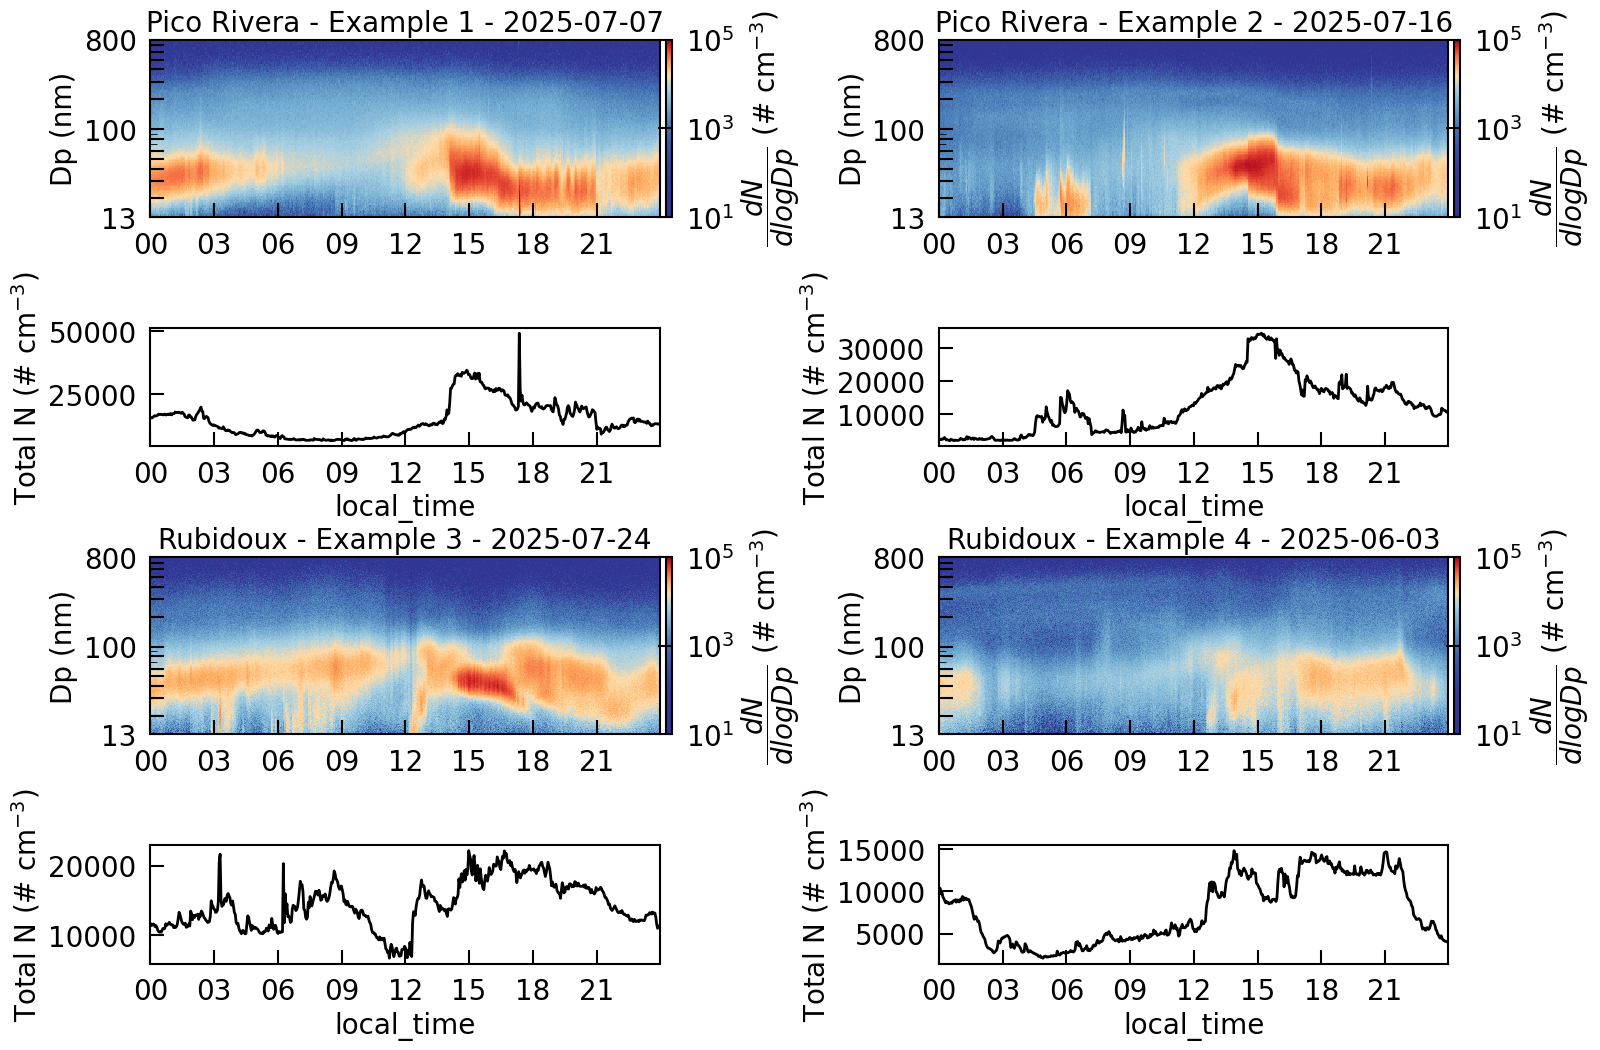

In [79]:
# Move to other code, keep this one too 
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

custom_cmap = warp_colormap(base_cmap, high_end_bias)

def get_day_data(df, Z_all, mid_Dp, date_str):
    date = pd.to_datetime(date_str).date()
    df = df.copy()
    df['local_time'] = pd.to_datetime(df['local_time'])
    df['date'] = df['local_time'].dt.date

    mask = df['date'] == date

    if mask.sum() == 0:
        raise ValueError(f"No data found for date {date_str} in the dataframe.")

    df_day = df[mask]
    X = mdates.date2num(df_day['local_time'])

    z_day = Z_all[:, mask.values]  # Use .values to index numpy array

    return X, mid_Dp, z_day, df_day

# Define which days and sites to show

plot_info = [
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2025-07-07', 'Pico Rivera - Example 1', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2025-07-16', 'Pico Rivera - Example 2', 1e5),
    (dfr, dNdlogDp_stpr.T, mid_Dr, '2025-07-24', 'Rubidoux - Example 3', 1e5),
    (dfr, dNdlogDp_stpr.T, mid_Dr, '2025-06-03', 'Rubidoux - Example 4', 1e5),
]

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 2, height_ratios=[3, 2, 3, 2], hspace=0.75, wspace=0.3)

for i, (df, Z, mid_D, date, name, vmax) in enumerate(plot_info):
    Z_masked = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))
    X, Y, z_day, df_day = get_day_data(df, Z_masked, mid_D, date)

    col_row = 0 if i < 2 else 2
    col_col = i % 2

    start = pd.to_datetime(date + ' 00:00')
    end = pd.to_datetime(date + ' 23:59')

    # meshgrid for pcolormesh
    XX, YY = np.meshgrid(X, Y)

    # --- Colormap plot ---
    ax1 = fig.add_subplot(gs[col_row, col_col])
    pcm = ax1.pcolormesh(XX, YY, z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=vmax))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'{name} - {date}')

    def log_tick_formatter(val, pos=None):
        exponent = int(np.log10(val))
        return f'$10^{{{exponent}}}$'

    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    cbar.ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

    # --- Mean magnitude plot ---
    ax2 = fig.add_subplot(gs[col_row + 1, col_col], sharex=ax1)
    ax2.plot(df_day['local_time'], df_day['N_stp'], color='black', lw=2)
    ax2.set_ylabel('Total N (# cm$^{-3}$)')

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlim(start, end)

    ax2.set_xlabel('local_time')


    # Align bottom plot width to top plot width
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])


plt.tight_layout(rect=[0, 0, 0.9, 1])
filename = os.path.join(output_folder, f'pico_rubi_4_panel_event_plot.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
# keep fig
plt.show()


## Average N_stp over whole dataset (Weekend Versus Weekday)

Pico Rivera Sample Weekday Dates (with weekday name):
2025-06-02 (Monday)
2025-06-03 (Tuesday)
2025-06-04 (Wednesday)
2025-06-05 (Thursday)
2025-06-06 (Friday)
2025-06-09 (Monday)
2025-06-10 (Tuesday)
2025-06-11 (Wednesday)
2025-06-12 (Thursday)
2025-06-13 (Friday)

Pico Rivera Sample Weekend Dates (with weekday name):
2025-05-31 (Saturday)
2025-06-01 (Sunday)
2025-06-07 (Saturday)
2025-06-08 (Sunday)
2025-06-14 (Saturday)
2025-06-15 (Sunday)
2025-06-21 (Saturday)
2025-06-22 (Sunday)
2025-06-28 (Saturday)
2025-06-29 (Sunday)

Rubidoux Sample Weekday Dates (with weekday name):
2025-06-02 (Monday)
2025-06-03 (Tuesday)
2025-06-04 (Wednesday)
2025-06-05 (Thursday)
2025-06-06 (Friday)
2025-06-09 (Monday)
2025-06-10 (Tuesday)
2025-06-11 (Wednesday)
2025-06-12 (Thursday)
2025-06-13 (Friday)

Rubidoux Sample Weekend Dates (with weekday name):
2025-05-31 (Saturday)
2025-06-01 (Sunday)
2025-06-07 (Saturday)
2025-06-08 (Sunday)
2025-06-14 (Saturday)
2025-06-15 (Sunday)
2025-06-21 (Saturday)
2025-

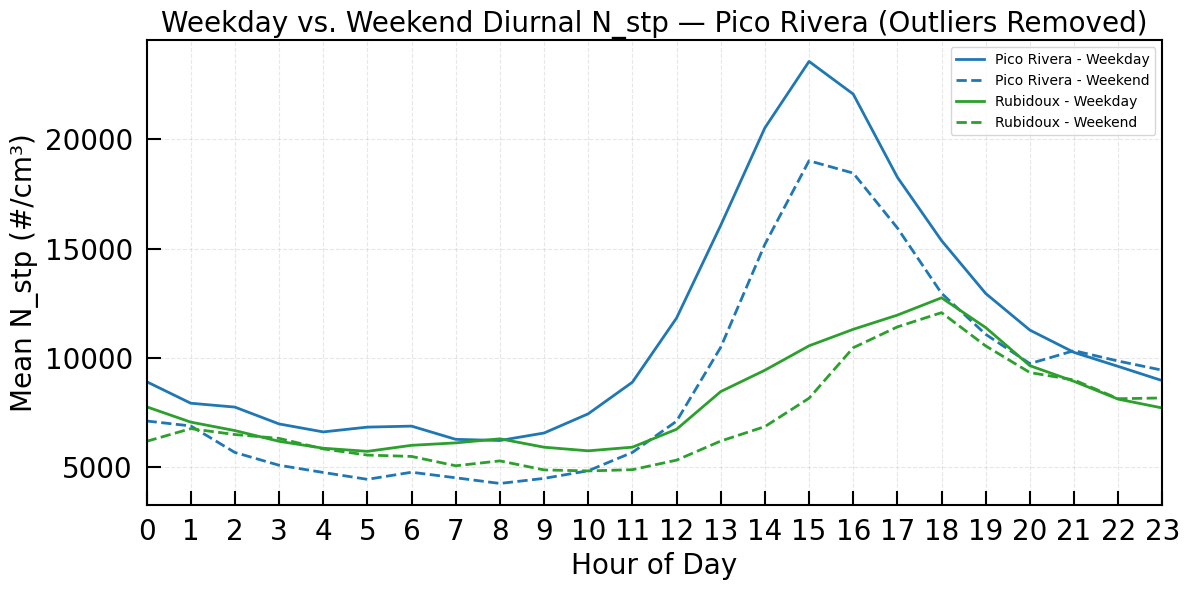

In [80]:
# Move to other code, keep this here
lower_p = dfp['N_stp'].quantile(0.01)
upper_p = dfp['N_stp'].quantile(0.99)
dfp_no_outliers = dfp[(dfp['N_stp'] >= lower_p) & (dfp['N_stp'] <= upper_p)].copy()

# Remove outliers from dfr similarly
lower_r = dfr['N_stp'].quantile(0.01)
upper_r = dfr['N_stp'].quantile(0.99)
dfr_no_outliers = dfr[(dfr['N_stp'] >= lower_r) & (dfr['N_stp'] <= upper_r)].copy()

# Make sure hour and dayofweek columns exist in the filtered dataframes
for df in [dfp_no_outliers, dfr_no_outliers]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6
    
# Create weekday and weekend masks
weekday_mask_p = dfp_no_outliers['dayofweek'].isin(range(5))  # 0-4
weekend_mask_p = dfp_no_outliers['dayofweek'].isin([5,6])     # 5-6

weekday_mask_r = dfr_no_outliers['dayofweek'].isin(range(5))
weekend_mask_r = dfr_no_outliers['dayofweek'].isin([5,6])

# Group by hour and take mean N_stp for weekdays and weekends
weekday_p = dfp_no_outliers[weekday_mask_p].groupby('hour')['N_stp'].mean()
weekend_p = dfp_no_outliers[weekend_mask_p].groupby('hour')['N_stp'].mean()

weekday_r = dfr_no_outliers[weekday_mask_r].groupby('hour')['N_stp'].mean()
weekend_r = dfr_no_outliers[weekend_mask_r].groupby('hour')['N_stp'].mean()

#################
# Print statements below allow you to double check in your calendar 
# that the dates were properly sorted into their respective days of the week

# Print samples for Pico Rivera (dfp_no_outliers)
print("Pico Rivera Sample Weekday Dates (with weekday name):")
for d in dfp_no_outliers[weekday_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

print("\nPico Rivera Sample Weekend Dates (with weekday name):")
for d in dfp_no_outliers[weekend_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

# Print samples for Rubidoux (dfp_no_outliers)
print("\nRubidoux Sample Weekday Dates (with weekday name):")
for d in dfr_no_outliers[weekday_mask_r]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

print("\nRubidoux Sample Weekend Dates (with weekday name):")
for d in dfr_no_outliers[weekend_mask_r]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

#################

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(weekday_p.index, weekday_p, label='Pico Rivera - Weekday', color='tab:blue', linewidth=2)
plt.plot(weekend_p.index, weekend_p, label='Pico Rivera - Weekend', color='tab:blue', linestyle='--', linewidth=2)

plt.plot(weekday_r.index, weekday_r, label='Rubidoux - Weekday', color='tab:green', linewidth=2)
plt.plot(weekend_r.index, weekend_r, label='Rubidoux - Weekend', color='tab:green', linestyle='--', linewidth=2)

plt.xlabel('Hour of Day')
plt.ylabel('Mean N_stp (#/cm³)')
plt.title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')
plt.legend()
# plt.xlabel('Hour of Day', fontsize=12)
# plt.ylabel('Mean N_stp (#/cm³)', fontsize=12)
# plt.title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)', fontsize=14)
# plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))  # Show all hours 0 through 23

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
# keep fig

plt.show()

## Average N_stp and BC (30_min_avg) over whole dataset (Weekend Versus Weekday)

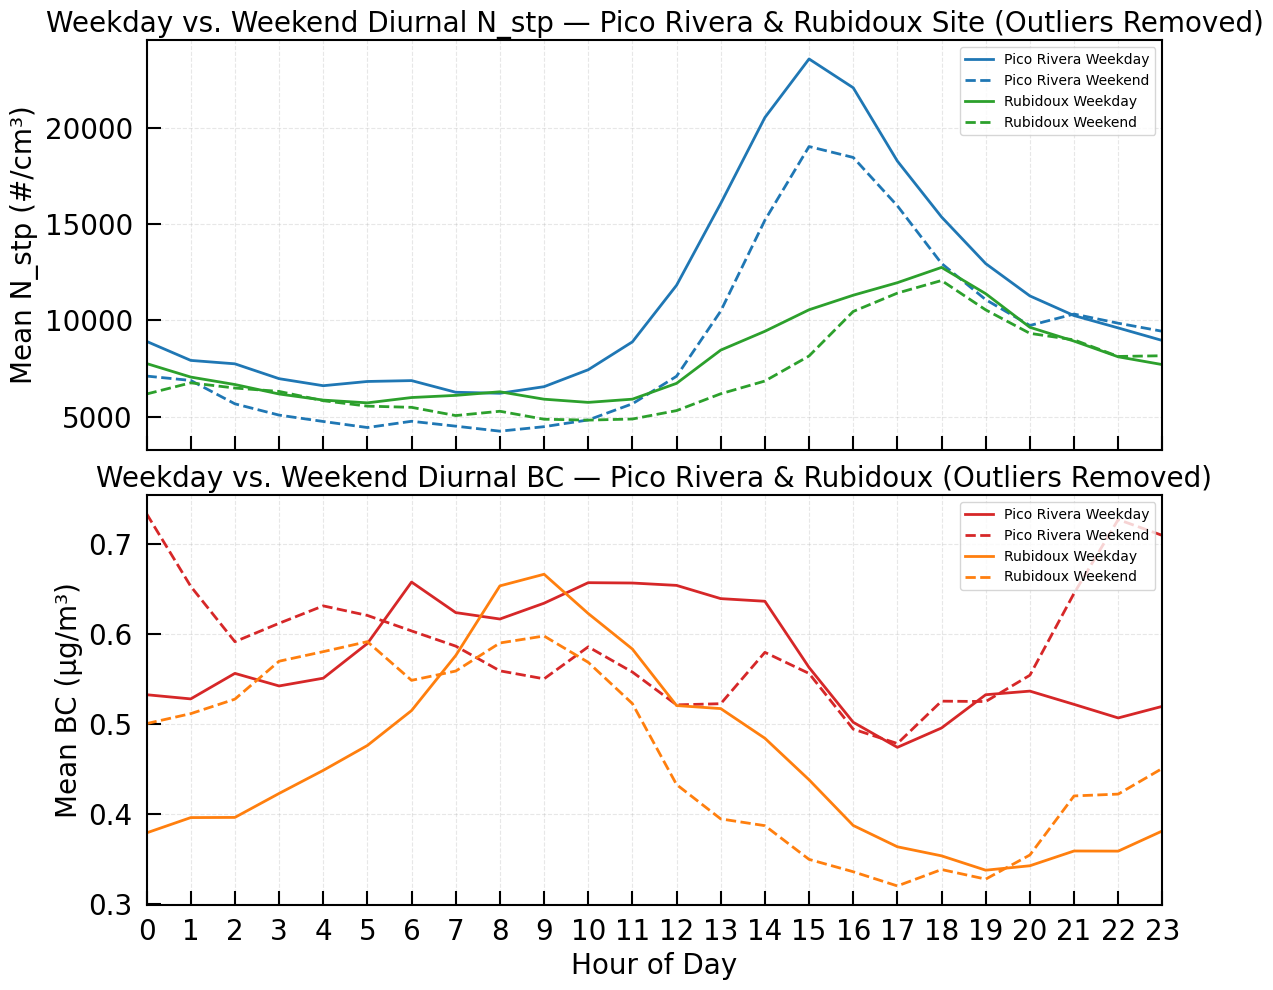

In [81]:
# Adapted

# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Prepare function to compute weekday/weekend means ---
def prepare_weekday_weekend_means(df, time_col, nstp_col, bc_col):
    # Remove outliers separately for N_stp and BC
    df_nstp = remove_outliers(df, nstp_col)
    df_bc = remove_outliers(df, bc_col)
    
    for d in [df_nstp, df_bc]:
        d[time_col] = pd.to_datetime(d[time_col], errors='coerce')
        d['hour'] = d[time_col].dt.hour
        d['dayofweek'] = d[time_col].dt.dayofweek  # Monday=0
    
    # Masks
    weekday_mask_n = df_nstp['dayofweek'].isin(range(5))
    weekend_mask_n = df_nstp['dayofweek'].isin([5, 6])
    weekday_mask_bc = df_bc['dayofweek'].isin(range(5))
    weekend_mask_bc = df_bc['dayofweek'].isin([5, 6])
    
    # Group means
    weekday_nstp = df_nstp[weekday_mask_n].groupby('hour')[nstp_col].mean()
    weekend_nstp = df_nstp[weekend_mask_n].groupby('hour')[nstp_col].mean()
    weekday_bc = df_bc[weekday_mask_bc].groupby('hour')[bc_col].mean()
    weekend_bc = df_bc[weekend_mask_bc].groupby('hour')[bc_col].mean()
    
    return weekday_nstp, weekend_nstp, weekday_bc, weekend_bc

# --- 3️⃣ Process both sites ---
# dfp = Pico Rivera
# dfr = Rubidoux
weekday_n_pico, weekend_n_pico, weekday_bc_pico, weekend_bc_pico = prepare_weekday_weekend_means(
    dfp, 'local_time', 'N_stp', '30_min_avg'
)
weekday_n_rubi, weekend_n_rubi, weekday_bc_rubi, weekend_bc_rubi = prepare_weekday_weekend_means(
    dfr, 'local_time', 'N_stp', '30_min_avg'
)

# --- 4️⃣ Plot ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Top: N_stp ---
axes[0].plot(weekday_n_pico.index, weekday_n_pico, label='Pico Rivera Weekday', color='tab:blue', linewidth=2)
axes[0].plot(weekend_n_pico.index, weekend_n_pico, label='Pico Rivera Weekend', color='tab:blue', linestyle='--', linewidth=2)
axes[0].plot(weekday_n_rubi.index, weekday_n_rubi, label='Rubidoux Weekday', color='tab:green', linewidth=2)
axes[0].plot(weekend_n_rubi.index, weekend_n_rubi, label='Rubidoux Weekend', color='tab:green', linestyle='--', linewidth=2)
axes[0].set_ylabel('Mean N_stp (#/cm³)')
axes[0].set_title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera & Rubidoux Site (Outliers Removed)')
# axes[0].set_ylabel('Mean N_stp (#/cm³)', fontsize=12)
# axes[0].set_title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera & Rubidoux Site (Outliers Removed)', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# --- Bottom: BC ---
axes[1].plot(weekday_bc_pico.index, weekday_bc_pico, label='Pico Rivera Weekday', color='tab:red', linewidth=2)
axes[1].plot(weekend_bc_pico.index, weekend_bc_pico, label='Pico Rivera Weekend', color='tab:red', linestyle='--', linewidth=2)
axes[1].plot(weekday_bc_rubi.index, weekday_bc_rubi, label='Rubidoux Weekday', color='tab:orange', linewidth=2)
axes[1].plot(weekend_bc_rubi.index, weekend_bc_rubi, label='Rubidoux Weekend', color='tab:orange', linestyle='--', linewidth=2)
axes[1].set_ylabel('Mean BC (µg/m³)')
axes[1].set_xlabel('Hour of Day')
axes[1].set_title('Weekday vs. Weekend Diurnal BC — Pico Rivera & Rubidoux (Outliers Removed)')
# axes[1].set_ylabel('Mean BC (µg/m³)', fontsize=12)
# axes[1].set_xlabel('Hour of Day', fontsize=12)
# axes[1].set_title('Weekday vs. Weekend Diurnal BC — Pico Rivera & Rubidoux (Outliers Removed)', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.tight_layout()
filename = os.path.join(output_folder, 'weekend_vs_weekday_N_stp_BC_pico_rubi.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Event Frequency

- These are estimated frequencies, you will need to define your own how you wish

- Feel free to change the frequencies here and even the variable name from pico_freq, just be sure to change the varable name from pico_freq to the name you picked in the lines: 

    bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4') 
    
    bars2 = ax.bar(x + width/2, rubi_freq, width, label='Rubidoux', color='#ff7f0e') 

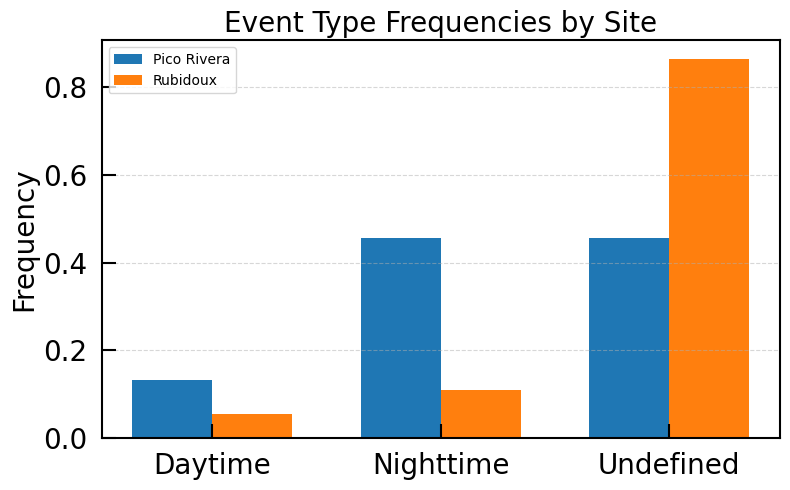

In [82]:
# Skip for now
# Move to other code

# Example data
event_types = ['Daytime', 'Nighttime', 'Undefined'] # these can have different names
pico_freq = [0.13333333333333333, 0.45555555555555555, 0.45555555555555555] # change the frequencies
rubi_freq = [0.0547945205479452, 0.1095890410958904, 0.863013698630137] # change the frequencies

x = np.arange(len(event_types))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, pico_freq, width, label='Pico Rivera', color='#1f77b4')
bars2 = ax.bar(x + width/2, rubi_freq, width, label='Rubidoux', color='#ff7f0e')

# Labels and styling
ax.set_ylabel('Frequency')
ax.set_title('Event Type Frequencies by Site')
ax.set_xticks(x)
ax.set_xticklabels(event_types)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5, axis='y')

plt.tight_layout()
filename = os.path.join(output_folder, 'event_frequencies_pico_rubi.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Average Particle size distributions

Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

Divide the dataset into day and night, and then calculate the average size distributions during those time periods for the whole dataset

In [98]:
tsdfp

,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),Impactor D50 (nm),...,572.55,593.52,615.27,637.80,661.17,685.39,710.50,736.53,763.51,791.48
local_time,,,,,,,,,,,,,,,,,,,,,
2025-05-31 17:02:06,3954.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,196.994,0.010,0.010,51.674,0.010,53.899,0.010,0.010,0.010,26.352
2025-05-31 17:04:38,3955.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.034,50.341,50.785,0.010,52.565,53.465,54.343,54.026,0.010,0.010
2025-05-31 17:07:10,3956.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,0.010,52.565,0.010,0.010,0.010,0.010,0.010
2025-05-31 17:09:41,3957.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.463,0.010,51.235,0.010,0.010,53.457,0.010,0.010,0.010,25.280
2025-05-31 17:12:12,3958.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,52.124,0.010,0.010,54.343,0.010,0.010,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01 14:34:52,1759.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,52.048,0.010,53.396,0.010,0.010,38.276,57.077
2025-08-01 14:37:24,1760.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,100.560,0.010,52.048,157.943,0.010,0.010,47.916,0.010,31.976
2025-08-01 14:39:55,1761.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.076,0.010,51.034,51.615,0.010,0.010,54.272,47.625,0.010,0.010


In [107]:
df_copyp = tsdfp.copy()
df_copyr = tsdfr.copy()

In [108]:
df_copyp

,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),Impactor D50 (nm),...,572.55,593.52,615.27,637.80,661.17,685.39,710.50,736.53,763.51,791.48
local_time,,,,,,,,,,,,,,,,,,,,,
2025-05-31 17:02:06,3954.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,196.994,0.010,0.010,51.674,0.010,53.899,0.010,0.010,0.010,26.352
2025-05-31 17:04:38,3955.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.034,50.341,50.785,0.010,52.565,53.465,54.343,54.026,0.010,0.010
2025-05-31 17:07:10,3956.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,0.010,52.565,0.010,0.010,0.010,0.010,0.010
2025-05-31 17:09:41,3957.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.463,0.010,51.235,0.010,0.010,53.457,0.010,0.010,0.010,25.280
2025-05-31 17:12:12,3958.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,52.124,0.010,0.010,54.343,0.010,0.010,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01 14:34:52,1759.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,52.048,0.010,53.396,0.010,0.010,38.276,57.077
2025-08-01 14:37:24,1760.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,100.560,0.010,52.048,157.943,0.010,0.010,47.916,0.010,31.976
2025-08-01 14:39:55,1761.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.076,0.010,51.034,51.615,0.010,0.010,54.272,47.625,0.010,0.010


In [109]:
dfp

,local_time,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),...,615.27,637.80,661.17,685.39,710.50,736.53,763.51,791.48,N_stp,30_min_avg
0,2025-05-31 17:02:06,3954.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,0.010,51.674,0.010,53.899,0.010,0.010,0.010,26.352,13159.744046,0.000000
1,2025-05-31 17:04:38,3955.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,50.785,0.010,52.565,53.465,54.343,54.026,0.010,0.010,13443.483784,-0.140600
2,2025-05-31 17:07:10,3956.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,0.010,0.010,52.565,0.010,0.010,0.010,0.010,0.010,12318.121792,-0.203875
3,2025-05-31 17:09:41,3957.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,51.235,0.010,0.010,53.457,0.010,0.010,0.010,25.280,13563.261110,-0.242800
4,2025-05-31 17:12:12,3958.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,0.010,52.124,0.010,0.010,54.343,0.010,0.010,0.010,13747.231380,-0.094462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35334,2025-08-01 14:34:52,1759.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,0.010,52.048,0.010,53.396,0.010,0.010,38.276,57.077,28306.337523,0.716933
35335,2025-08-01 14:37:24,1760.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,0.010,52.048,157.943,0.010,0.010,47.916,0.010,31.976,27990.313006,0.703400
35336,2025-08-01 14:39:55,1761.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,51.034,51.615,0.010,0.010,54.272,47.625,0.010,0.010,27468.981497,0.693033
35337,2025-08-01 14:42:26,1762.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,...,51.161,0.010,0.010,53.829,0.010,99.183,42.986,31.003,27728.486016,0.686833


In [110]:
df_copyp

,Scan Number,Test Name,Detector Status,Classifier Errors,Communication Status,Neutralizer Status,Detector Inlet Flow (L/min),Detector Counting Flow (L/min),Impactor Flow (L/min),Impactor D50 (nm),...,572.55,593.52,615.27,637.80,661.17,685.39,710.50,736.53,763.51,791.48
local_time,,,,,,,,,,,,,,,,,,,,,
2025-05-31 17:02:06,3954.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,196.994,0.010,0.010,51.674,0.010,53.899,0.010,0.010,0.010,26.352
2025-05-31 17:04:38,3955.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.034,50.341,50.785,0.010,52.565,53.465,54.343,54.026,0.010,0.010
2025-05-31 17:07:10,3956.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,0.010,52.565,0.010,0.010,0.010,0.010,0.010
2025-05-31 17:09:41,3957.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.463,0.010,51.235,0.010,0.010,53.457,0.010,0.010,0.010,25.280
2025-05-31 17:12:12,3958.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,52.124,0.010,0.010,54.343,0.010,0.010,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01 14:34:52,1759.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,0.010,0.010,52.048,0.010,53.396,0.010,0.010,38.276,57.077
2025-08-01 14:37:24,1760.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,0.010,100.560,0.010,52.048,157.943,0.010,0.010,47.916,0.010,31.976
2025-08-01 14:39:55,1761.0,NaN,NaN,NaN,0.01,NaN,0.6,0.3,0.6,1000.0,...,49.076,0.010,51.034,51.615,0.010,0.010,54.272,47.625,0.010,0.010


## Start with the taking the average dNdlogDp across all times for Pico Rivera and Rubidoux

In [111]:

mean_spectrum_p = dNdlogDp_stpp.mean(axis=0)  # shape: (n_bins,)
mean_spectrum_r = dNdlogDp_stpr.mean(axis=0)  # shape: (n_bins,)


In [112]:
df_copyp.columns[concentration_columns_pico]

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='object', length=115)

In [113]:
df_copyr.columns[41:273]

Index(['12.98', '13.22', '13.46', '13.70', '13.95', '14.20', '14.46', '14.72',
       '14.99', '15.26',
       ...
       '704.14', '716.92', '729.93', '743.18', '756.67', '770.40', '784.39',
       '798.63', '813.12', '12.75'],
      dtype='object', length=232)

In [114]:
selected_colsp = df_copyp.columns[concentration_columns_pico]
bin_diametersp = np.array(selected_colsp).astype(float)
dNdlogDp_stpp_numeric = np.array(dNdlogDp_stpp, dtype='float')
# Mask out bins with all NaNs
valid_binsp = ~np.all(np.isnan(dNdlogDp_stpp_numeric), axis=0)

# Compute average across time for valid bins
mean_spectrum_p = np.nanmean(dNdlogDp_stpp_numeric[:, valid_binsp], axis=0)
bin_diameters_validp = bin_diametersp[valid_binsp]


In [115]:
selected_colsr = df_copyr.columns[concentration_columns_rubidoux]
bin_diametersr = np.array(selected_colsr).astype(float)
dNdlogDp_stpr_numeric = np.array(dNdlogDp_stpr, dtype='float')
# Mask out bins with all NaNs
valid_binsr = ~np.all(np.isnan(dNdlogDp_stpr_numeric), axis=0)

# Compute average across time for valid bins
mean_spectrum_r = np.nanmean(dNdlogDp_stpr_numeric[:, valid_binsr], axis=0)
bin_diameters_validr = bin_diametersr[valid_binsr]



# Plot the averages for both sites

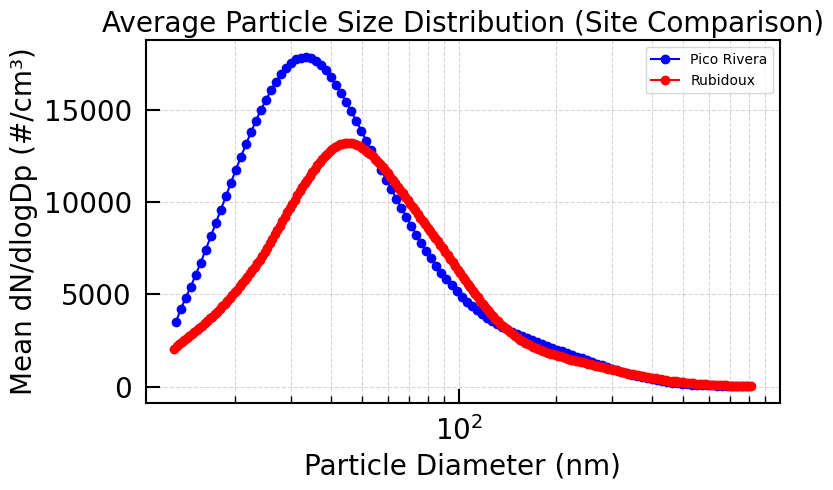

In [116]:
# Move to other code, comment out here
plt.figure(figsize=(8, 5))

# Site 1: your original data
plt.plot(bin_diameters_validp, mean_spectrum_p, marker='o', label='Pico Rivera', color='blue')

# Site 2: comparison site (dotted red line)
plt.plot(bin_diameters_validr, mean_spectrum_r, marker='o', label='Rubidoux', color='red')

plt.xscale('log')
plt.xlabel('Particle Diameter (nm)')
plt.ylabel('Mean dN/dlogDp (#/cm³)')
plt.title('Average Particle Size Distribution (Site Comparison)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
filename = os.path.join(output_folder, 'avg_size_dist_pico_rubi.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Calculate and plot the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

In [117]:
df_copyp = df_copyp.reset_index()
df_copyr = df_copyr.reset_index()

In [118]:
# Convert timestamp column to datetime, if not already
df_copyp['local_time'] = pd.to_datetime(df_copyp['local_time'])

# Extract hour
df_copyp['hour'] = df_copyp['local_time'].dt.hour

# Convert timestamp column to datetime, if not already
df_copyr['local_time'] = pd.to_datetime(df_copyr['local_time'])

# Extract hour
df_copyr['hour'] = df_copyr['local_time'].dt.hour


In [119]:
# Daytime: 09:00–20:00
day_maskp = df_copyp['hour'].between(9, 20)

# Nighttime: 21:00–23:59 and 00:00–08:59
night_maskp = ~day_maskp  # everything else



# Daytime: 09:00–20:00
day_maskr = df_copyr['hour'].between(9, 20)

# Nighttime: 21:00–23:59 and 00:00–08:59
night_maskr = ~day_maskr  # everything else


In [120]:
# Convert dNdlogDp_stpp to numeric if not already done
dNdlogDp_stpp_numeric = pd.DataFrame(dNdlogDp_stpp).apply(pd.to_numeric, errors='coerce').values

# Apply masks to get subsets
dNdlogDp_dayp = dNdlogDp_stpp_numeric[day_maskp.values]
dNdlogDp_nightp = dNdlogDp_stpp_numeric[night_maskp.values]



# Convert dNdlogDp_stpp to numeric if not already done
dNdlogDp_stpr_numeric = pd.DataFrame(dNdlogDp_stpr).apply(pd.to_numeric, errors='coerce').values

# Apply masks to get subsets
dNdlogDp_dayr = dNdlogDp_stpr_numeric[day_maskr.values]
dNdlogDp_nightr = dNdlogDp_stpr_numeric[night_maskr.values]


In [121]:
mean_dayp = np.nanmean(dNdlogDp_dayp, axis=0)
mean_nightp = np.nanmean(dNdlogDp_nightp, axis=0)


mean_dayr = np.nanmean(dNdlogDp_dayr, axis=0)
mean_nightr = np.nanmean(dNdlogDp_nightr, axis=0)


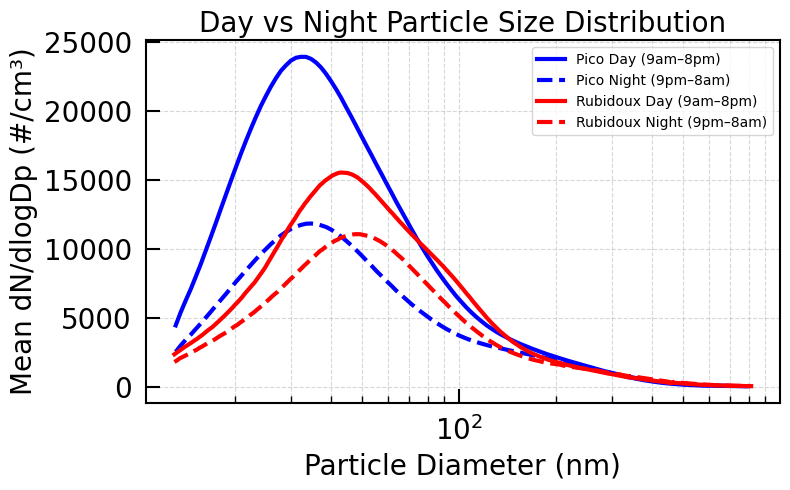

In [122]:
plt.figure(figsize=(8, 5))

plt.plot(bin_diameters_validp, mean_dayp, label='Pico Day (9am–8pm)', color='blue', linewidth=3)
plt.plot(bin_diameters_validp, mean_nightp, label='Pico Night (9pm–8am)', color='blue', linestyle='--', linewidth=3)

plt.plot(bin_diameters_validr, mean_dayr, label='Rubidoux Day (9am–8pm)', color='red', linewidth=3)
plt.plot(bin_diameters_validr, mean_nightr, label='Rubidoux Night (9pm–8am)', color='red', linestyle='--', linewidth=3)

plt.xscale('log')
plt.xlabel('Particle Diameter (nm)')
plt.ylabel('Mean dN/dlogDp (#/cm³)')
plt.title('Day vs Night Particle Size Distribution')
# plt.xlabel('Particle Diameter (nm)', fontsize=18)
# plt.ylabel('Mean dN/dlogDp (#/cm³)', fontsize=18)
# plt.title('Day vs Night Particle Size Distribution', fontsize=22)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
filename = os.path.join(output_folder, 'avg_size_dist_day_vs_night_pico_rubi.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Put the total and day/night averages on same figure

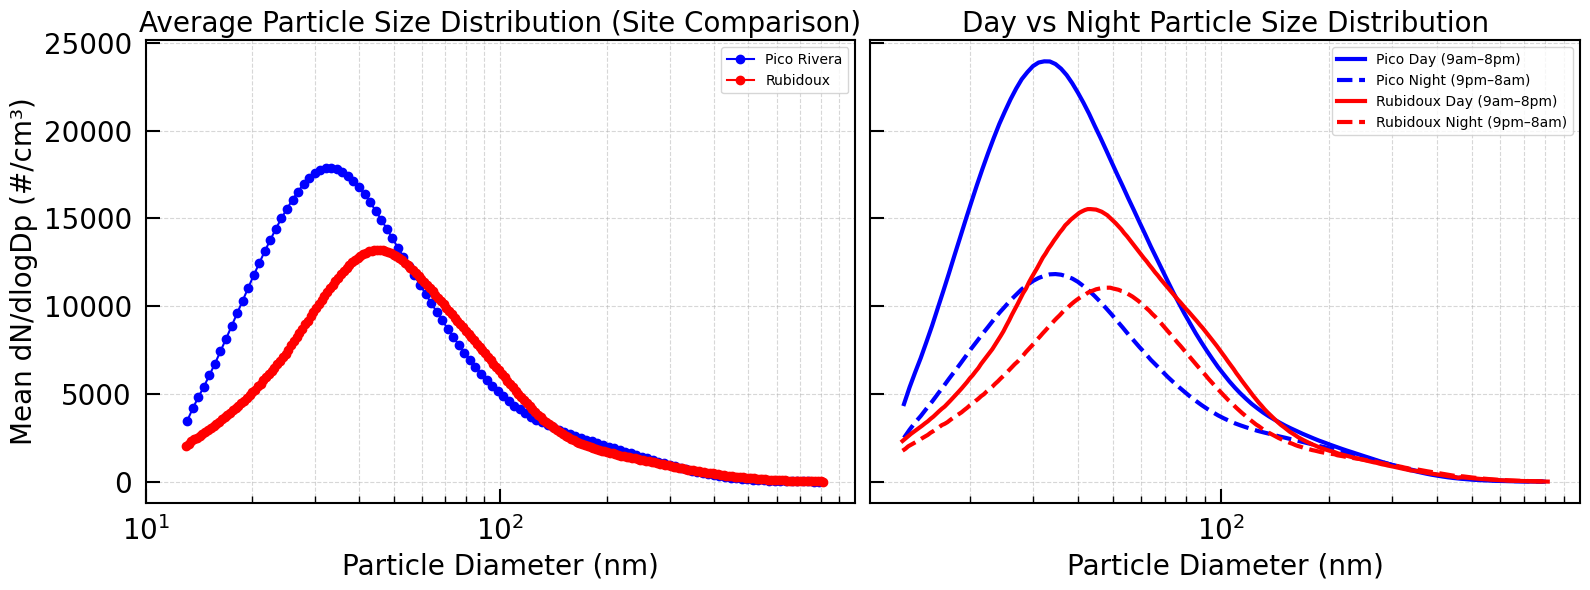

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 cols, share y-axis

# First subplot: Average size distribution comparison
axes[0].plot(bin_diameters_validp, mean_spectrum_p, marker='o', label='Pico Rivera', color='blue')
axes[0].plot(bin_diameters_validr, mean_spectrum_r, marker='o', label='Rubidoux', color='red')

axes[0].set_xscale('log')
axes[0].set_xlabel('Particle Diameter (nm)')
axes[0].set_ylabel('Mean dN/dlogDp (#/cm³)')
axes[0].set_title('Average Particle Size Distribution (Site Comparison)')
axes[0].tick_params(axis='both', which='major')

axes[0].grid(True, which='both', linestyle='--', alpha=0.5)
axes[0].set_xticks([10, 100])

axes[0].legend()
# axes[0].legend(fontsize=16)

# Second subplot: Day vs Night for both sites
axes[1].plot(bin_diameters_validp, mean_dayp, label='Pico Day (9am–8pm)', color='blue', linewidth=3)
axes[1].plot(bin_diameters_validp, mean_nightp, label='Pico Night (9pm–8am)', color='blue', linestyle='--', linewidth=3)

axes[1].plot(bin_diameters_validr, mean_dayr, label='Rubidoux Day (9am–8pm)', color='red', linewidth=3)
axes[1].plot(bin_diameters_validr, mean_nightr, label='Rubidoux Night (9pm–8am)', color='red', linestyle='--', linewidth=3)

axes[1].set_xscale('log')
axes[1].set_xlabel('Particle Diameter (nm)')
axes[1].set_title('Day vs Night Particle Size Distribution')
axes[1].tick_params(axis='both', which='major')
# axes[1].set_xlabel('Particle Diameter (nm)', fontsize=16)
# axes[1].set_title('Day vs Night Particle Size Distribution', fontsize=16)
# axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].grid(True, which='both', linestyle='--', alpha=0.5)
axes[1].legend()
# axes[1].legend(fontsize=16)



plt.tight_layout()
filename = os.path.join(output_folder, 'avg_size_dist_pico_rubi_2_panel.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

# Average Total Number Concentration per Weekday

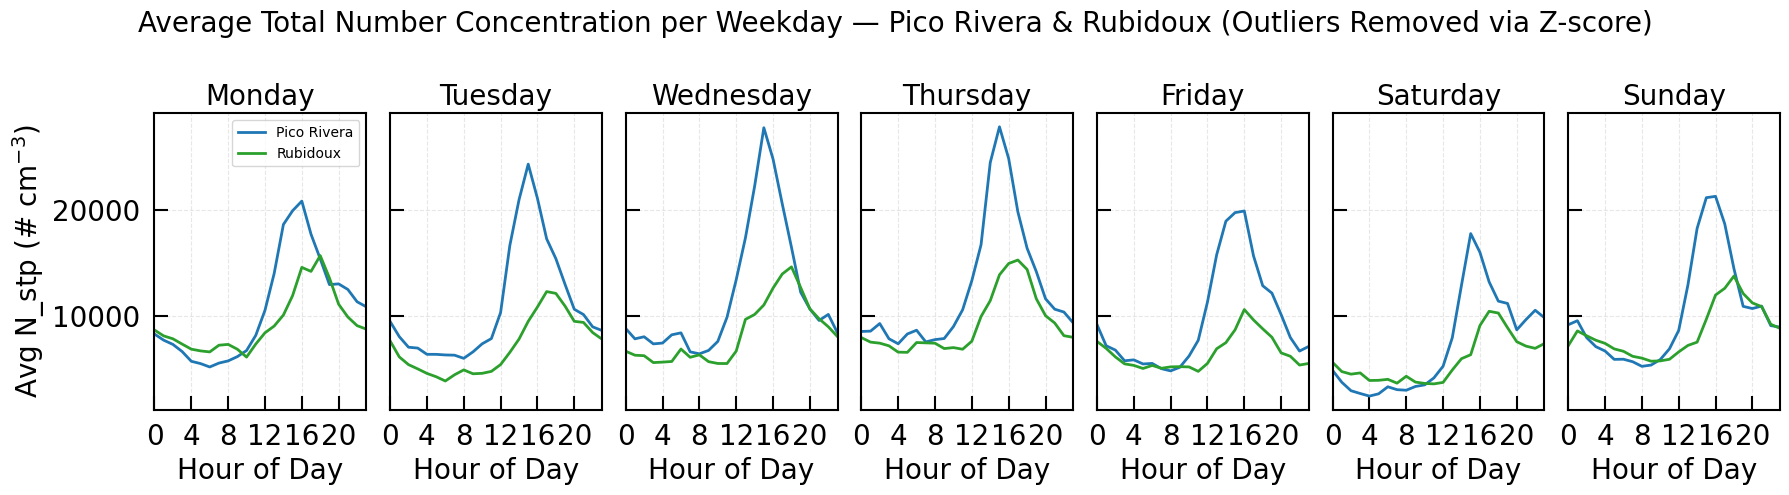

In [124]:
# Adapted

from scipy.stats import zscore

# --- 1️⃣ Function to clean data ---
def clean_and_prep(df):
    df = df.copy()
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df = df.set_index('local_time')
    df = df.dropna(subset=['N_stp'])
    # Remove outliers with z-score
    df = df[np.abs(zscore(df['N_stp'].astype(float), nan_policy='omit')) < 3]
    df['weekday'] = df.index.day_name()
    return df

# --- 2️⃣ Clean both datasets ---
dfp_clean = clean_and_prep(dfp)
dfr_clean = clean_and_prep(dfr)

# --- 3️⃣ Weekday order & groups ---
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_groups_pico = [(day, dfp_clean[dfp_clean['weekday'] == day]) for day in ordered_days]
weekday_groups_rubi = [(day, dfr_clean[dfr_clean['weekday'] == day]) for day in ordered_days]

# --- 4️⃣ Plot ---
fig, axs = plt.subplots(1, 7, figsize=(18, 5), sharey=True)
axs = axs.flatten()

for i, ((day_pico, group_pico), (_, group_rubi)) in enumerate(zip(weekday_groups_pico, weekday_groups_rubi)):
    # Pico Rivera line
    if not group_pico.empty:
        avg_diurnal_pico = group_pico.groupby(group_pico.index.hour)['N_stp'].mean()
        axs[i].plot(avg_diurnal_pico.index, avg_diurnal_pico.values, color='tab:blue', linewidth=2, label='Pico Rivera')
    # Rubidoux line
    if not group_rubi.empty:
        avg_diurnal_rubi = group_rubi.groupby(group_rubi.index.hour)['N_stp'].mean()
        axs[i].plot(avg_diurnal_rubi.index, avg_diurnal_rubi.values, color='tab:green', linewidth=2, label='Rubidoux')

    axs[i].set_title(day_pico)
    axs[i].set_xlabel('Hour of Day')
    axs[i].set_xlim(0, 23)
    axs[i].set_xticks(range(0, 24, 4))
    axs[i].grid(True, linestyle='--', alpha=0.3)

    if i == 0:
        axs[i].set_ylabel('Avg N_stp (# cm$^{-3}$)')

# Legend in first subplot only
axs[0].legend()
# axs[0].legend(fontsize=9)

# --- 5️⃣ Formatting ---
plt.suptitle('Average Total Number Concentration per Weekday — Pico Rivera & Rubidoux (Outliers Removed via Z-score)')
# plt.suptitle('Average Total Number Concentration per Weekday — Pico Rivera & Rubidoux (Outliers Removed via Z-score)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# filename = os.path.join(output_folder, 'pico_rubi_avg_N_stp_per_weekday.png')
# plt.savefig(filename, dpi=300, bbox_inches='tight')
filename = os.path.join(output_folder, 'pico_rubi_avg_N_stp_per_weekday.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## N_stp averaged and BC over days of the week for the whole dataset

In [125]:
# Ensure datetime
dfp['local_time'] = pd.to_datetime(dfp['local_time'], errors='coerce')
dfr['local_time'] = pd.to_datetime(dfr['local_time'], errors='coerce')

# Drop rows with invalid datetimes
dfp = dfp.dropna(subset=['local_time'])
dfr = dfr.dropna(subset=['local_time'])

# Set datetime as index
dfp = dfp.set_index('local_time')
dfr = dfr.set_index('local_time')

# Add weekday column
dfp['weekday'] = dfp.index.day_name()
dfr['weekday'] = dfr.index.day_name()


In [126]:
dfp['weekday'].value_counts()
dfr['weekday'].value_counts()


weekday
Wednesday    5151
Thursday     5146
Tuesday      5134
Sunday       5131
Monday       5131
Friday       4978
Saturday     4726
Name: count, dtype: int64

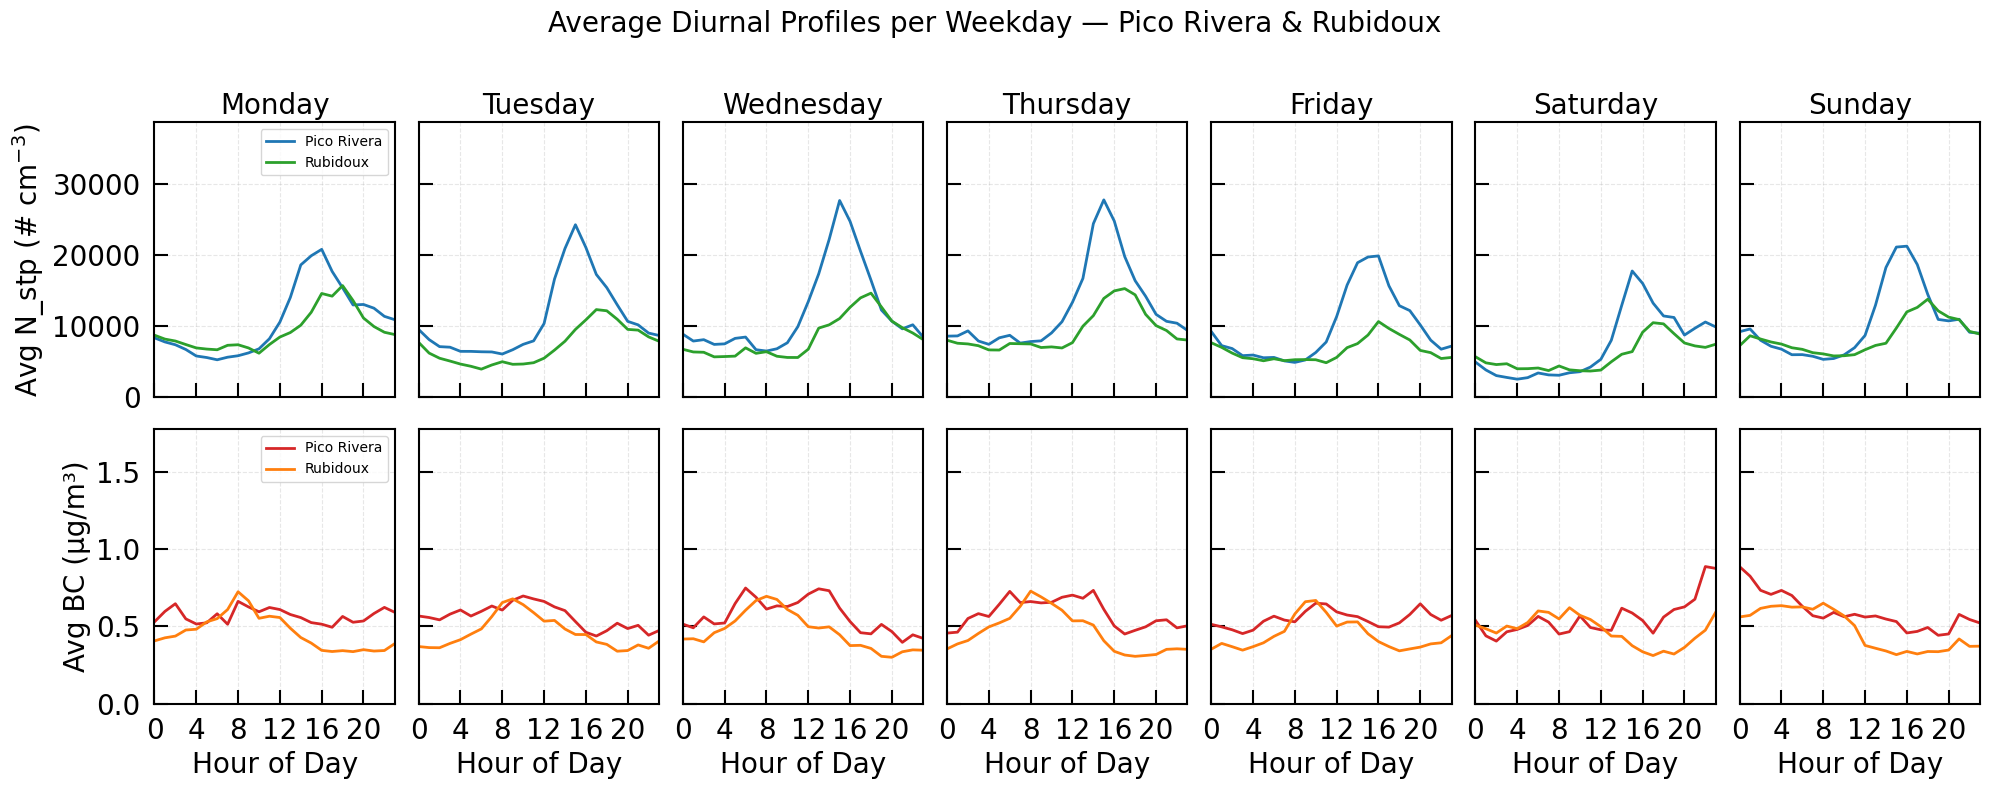

In [127]:
# Adapted



# --- 1️⃣ Filter outliers separately ---
def filter_outliers(df, col):
    if col in df.columns:
        return df[np.abs(zscore(df[col].astype(float), nan_policy='omit')) < 3].copy()
    return df.copy()

dfp_nstp = filter_outliers(dfp, 'N_stp')
dfr_nstp = filter_outliers(dfr, 'N_stp')

dfp_bc = filter_outliers(dfp, '30_min_avg')
dfr_bc = filter_outliers(dfr, '30_min_avg')

# --- 2️⃣ Create weekday groups ---
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_groups_pico_nstp = [(day, dfp_nstp[dfp_nstp['weekday'] == day]) for day in ordered_days]
weekday_groups_rubi_nstp = [(day, dfr_nstp[dfr_nstp['weekday'] == day]) for day in ordered_days]

weekday_groups_pico_bc = [(day, dfp_bc[dfp_bc['weekday'] == day]) for day in ordered_days]
weekday_groups_rubi_bc = [(day, dfr_bc[dfr_bc['weekday'] == day]) for day in ordered_days]

# --- 3️⃣ Plot ---
fig, axs = plt.subplots(2, 7, figsize=(20, 8), sharex=True, sharey='row')
axs = axs.reshape(2, 7)

# Row 1: N_stp
for i, ((day_pico, group_pico), (_, group_rubi)) in enumerate(zip(weekday_groups_pico_nstp, weekday_groups_rubi_nstp)):
    if not group_pico.empty:
        avg_pico = group_pico.groupby(group_pico.index.hour)['N_stp'].mean()
        axs[0, i].plot(avg_pico.index, avg_pico.values, color='tab:blue', linewidth=2, label='Pico Rivera')
    if not group_rubi.empty:
        avg_rubi = group_rubi.groupby(group_rubi.index.hour)['N_stp'].mean()
        axs[0, i].plot(avg_rubi.index, avg_rubi.values, color='tab:green', linewidth=2, label='Rubidoux')
    axs[0, i].set_title(day_pico)
    axs[0, i].set_xlim(0, 23)
    axs[0, i].set_xticks(range(0, 24, 4))
    axs[0, i].grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        axs[0, i].set_ylabel('Avg N_stp (# cm$^{-3}$)')

# Optional y-limit
max_nstp = max(dfp_nstp['N_stp'].max(), dfr_nstp['N_stp'].max())
axs[0, 0].set_ylim(0, max_nstp * 1.1)

# Row 2: BC (30_min_avg)
for i, ((day_pico, group_pico), (_, group_rubi)) in enumerate(zip(weekday_groups_pico_bc, weekday_groups_rubi_bc)):
    if '30_min_avg' in group_pico.columns and not group_pico.empty:
        avg_pico = group_pico.groupby(group_pico.index.hour)['30_min_avg'].mean()
        axs[1, i].plot(avg_pico.index, avg_pico.values, color='tab:red', linewidth=2, label='Pico Rivera')
    if '30_min_avg' in group_rubi.columns and not group_rubi.empty:
        avg_rubi = group_rubi.groupby(group_rubi.index.hour)['30_min_avg'].mean()
        axs[1, i].plot(avg_rubi.index, avg_rubi.values, color='tab:orange', linewidth=2, label='Rubidoux')
    axs[1, i].set_xlim(0, 23)
    axs[1, i].set_xticks(range(0, 24, 4))
    axs[1, i].grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        axs[1, i].set_ylabel('Avg BC (µg/m³)')

# Optional y-limit
max_bc = max(dfp_bc['30_min_avg'].max(), dfr_bc['30_min_avg'].max())
axs[1, 0].set_ylim(0, max_bc * 1.1)

# X-labels and legends
for ax in axs[1, :]:
    ax.set_xlabel('Hour of Day')
    axs[0, 0].legend()
    axs[1, 0].legend()

fig.suptitle('Average Diurnal Profiles per Weekday — Pico Rivera & Rubidoux')
# axs[0, 0].legend(fontsize=9)
# axs[1, 0].legend(fontsize=9)

# fig.suptitle('Average Diurnal Profiles per Weekday — Pico Rivera & Rubidoux', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
filename = os.path.join(output_folder, 'pico_rubi_avg_N_stp_BC_per_weekday.png')
# keep fig
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Average Total Number Concentration per Hour

/var/folders/nz/1bm2kv6d50jgrwznnh92sz7w0000gn/T/ipykernel_66060/90179138.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo')


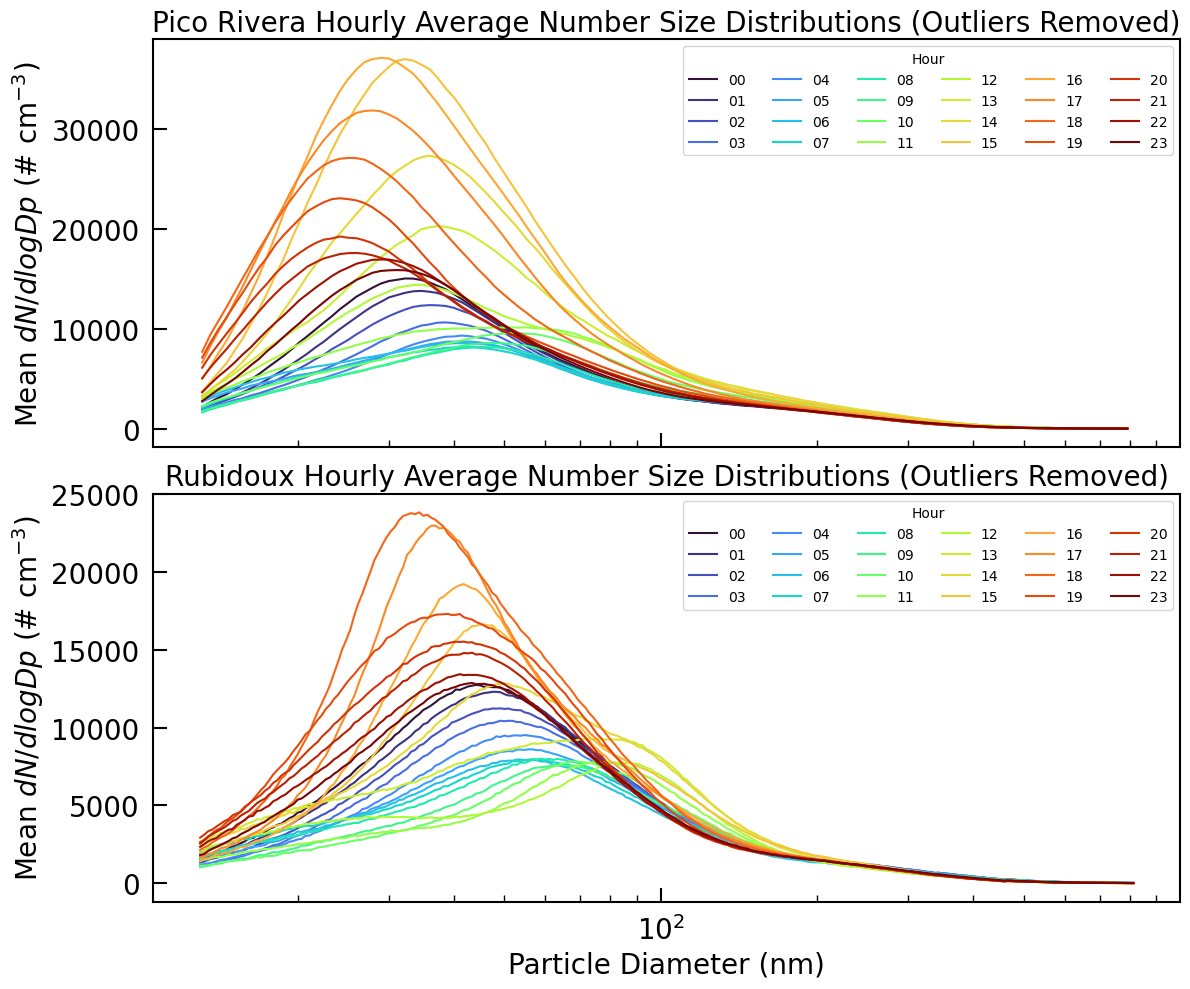

In [128]:
# Adapted


# --- 1️⃣ Convert to float arrays ---
dNdlogDp_stpp = np.asarray(dNdlogDp_stpp, dtype=float)
dNdlogDp_stpr = np.asarray(dNdlogDp_stpr, dtype=float)

# --- 2️⃣ Filter outliers per site ---
def filter_dNdlogDp(data, ts_df):
    z_scores = np.abs(zscore(data, axis=0, nan_policy='omit'))
    mask = (z_scores < 3).all(axis=1)
    filtered_data = data[mask]
    filtered_ts = ts_df[mask].copy()
    filtered_ts.index = pd.to_datetime(filtered_ts.index)
    filtered_ts['hour'] = filtered_ts.index.hour
    return filtered_data, filtered_ts

dNdlogDp_pp_filt, dfp_filt = filter_dNdlogDp(dNdlogDp_stpp, tsdfp)
dNdlogDp_pr_filt, dfr_filt = filter_dNdlogDp(dNdlogDp_stpr, tsdfr)

# --- 3️⃣ Hourly averages ---
hourly_avg_pp = pd.DataFrame(dNdlogDp_pp_filt, index=dfp_filt['hour']).groupby(level=0).mean()
hourly_avg_pr = pd.DataFrame(dNdlogDp_pr_filt, index=dfr_filt['hour']).groupby(level=0).mean()

# --- 4️⃣ Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

cmap = cm.get_cmap('turbo')

# Top: Pico Rivera
for hr in range(24):
    color = cmap(hr / 23)
    axs[0].plot(bin_diametersp, hourly_avg_pp.iloc[hr], color=color, label=f'{hr:02d}')
axs[0].set_xscale('log')
axs[0].set_ylabel('Mean $dN/dlogDp$ (# cm$^{-3}$)')
axs[0].set_title('Pico Rivera Hourly Average Number Size Distributions (Outliers Removed)')
axs[0].legend(ncol=6, title='Hour')
# axs[0].legend(ncol=6, fontsize=8, title='Hour')

# Bottom: Rubidoux
for hr in range(24):
    color = cmap(hr / 23)
    axs[1].plot(bin_diametersr, hourly_avg_pr.iloc[hr], color=color, label=f'{hr:02d}')
axs[1].set_xscale('log')
axs[1].set_xlabel('Particle Diameter (nm)')
axs[1].set_ylabel('Mean $dN/dlogDp$ (# cm$^{-3}$)')
axs[1].set_title('Rubidoux Hourly Average Number Size Distributions (Outliers Removed)')
axs[1].legend(ncol=6, title='Hour')
# axs[1].legend(ncol=6, fontsize=8, title='Hour')

plt.tight_layout()
filename = os.path.join(output_folder, 'hourly_avg_dNdlogDp_pico_rubi.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
# keep fig
plt.show()
